# Example: Parameter Uncertainty in Single Index Models (SIMs)
In this example, students will explore the question of parameter uncertainty in single index models. Single index models are widely used in finance to model the growth rate (return) of assets based on firm-specific factors and their relationship with a market index.

> __Learning Objectives:__
>
> By the end of this example, you will be able to:
> * __Estimate SIM parameters with confidence intervals__ using ordinary least squares regression to compute alpha and beta coefficients, along with their standard errors and 95% confidence intervals for multiple firms
> * __Evaluate model performance__ by computing R-squared values to assess the goodness of fit and interpret how well the market index explains individual firm returns
> * __Quantify parameter uncertainty through bootstrapping__ by generating synthetic datasets from fitted residuals and comparing bootstrap-derived confidence intervals with theoretical predictions

Let's go!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `12-31-2024`, along with data for several exchange-traded funds and volatility products during that time period. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [6]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"]; # original dataset

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [8]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow; # maximum number of trading days in our dataset

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [10]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Finally, let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable:

In [12]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of firm "ticker" symbols in alphabetical order

### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values:

In [14]:
Δt = (1.0/252.0); # time step

___

## Task 1: Estimate Single Index Models for All Firms in our Dataset
In this task, we'll estimate single index models for all firms in our dataset, including the 95% confidence intervals for the parameters. We'll use the `SPY` ETF as our market index.

Let's start by computing the growth rate matrix for all firms in the dataset. We've implemented [the `log_growth_matrix(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.log_growth_matrix) which takes the cleaned dataset and a list of ticker symbols, and returns the growth rate array. Each row of the growth rate array is a time step, while each column corresponds to a firm from the `list_of_tickers::Array{String,1}` array.

We'll save this data in the `growth_rate_array::Array{Float64,2}` variable:"

In [17]:
growth_rate_array = let

    # initialize -
    r̄ = 0.0; # assume the risk-free rate is 0

    # compute the growth matrix -
    growth_rate_array = log_growth_matrix(dataset, list_of_tickers, Δt = Δt, 
        risk_free_rate = r̄); # other optional parameters are at their defaults

    growth_rate_array; # return
end

2766×424 Matrix{Float64}:
 -0.877554    6.28105    -2.87097     …  -0.755391   0.245894  -1.00527
  2.81626     1.07149     1.39239         2.13832   -0.80279    0.986468
  3.31305     0.855597    0.00536803      0.109877   1.191     -2.58144
  0.646425   17.2599      1.69215         0.274716   3.1593    -0.368228
  1.81609     2.57961     3.31924         0.621677  -2.1687     4.40309
  0.61383    -3.96384    -0.79278     …  -0.862739  -1.90977   -3.11624
  2.86071    -0.483751    4.84573         1.7657    -1.77685   -1.0896
  2.04671     1.0135      1.90809         1.67597    4.44984   -0.137819
  1.31289     1.67413     0.107259       -1.50708   -2.13696    1.43784
  1.22016     6.12957     0.932578       -1.53202    2.87784   -1.43626
 -0.437668    4.87009     1.00774     …  -0.321261   9.50827   -3.00873
  1.36281     3.61317    -2.34776         0.710613   4.52223    0.340531
 -4.73904     1.38585    -3.01624        -2.15245   -6.64907    1.40612
  ⋮                                

Next, we need to pull out the growth rate of the market portfolio from `growth_rate_array::Array{Float64,2}`. To do this, look up the index for our market portfolio surrogate `SPY`, then store the growth rate (column from the growth rate array) in the `Gₘ::Array{Float64,1}` variable:

In [19]:
Gₘ = findfirst(x->x=="SPY", list_of_tickers) |> i -> growth_rate_array[:,i];

Now, let's estimate the single index model parameters for all firms in our dataset. For each firm, we compute the $\alpha$ and $\beta$ parameters using ordinary least squares, calculate the residual variance, and construct 95% confidence intervals based on the standard errors. 

We store the results in the `parameters_theory_dict::Dict{String, NamedTuple}` variable:

In [21]:
parameters_theory_dict = let

    # initialize -
    T = maximum_number_trading_days - 1; # number of time steps
    X̂ = [ones(T) Gₘ];
    p = 2; # number of parameters
    n = T; # number of training observations
    Δt  = (1/252); # time-step one-day in units of years (trading year is 252 days)
    t = 1.96; # for a 95% confidence interval
    data = Dict{String, NamedTuple}(); # dictionary to hold results

    for i ∈ eachindex(list_of_tickers)

        ticker = list_of_tickers[i]; # current ticker symbol
        yᵢ = findfirst(x-> x== ticker, list_of_tickers) |> j-> growth_rate_array[:, j];  # get the growth values for ticker
        θ̂ᵢ = inv(transpose(X̂) * X̂) * transpose(X̂) * yᵢ; # compute the SIM parameters for ticker
        rᵢ = yᵢ .- X̂*θ̂ᵢ; # residual vector
        my_training_variance = (1/Δt)*(1/(n-p))*norm(rᵢ)^2; # training variance
        SEᵢ = sqrt.(diag(inv(transpose(X̂)*X̂))*my_training_variance*Δt);  # compute the standard error

        # save the results in a named tuple
        dtp = ( 
            ticker = ticker,
            n = n,
            p = p,
            t = t,
            alpha = θ̂ᵢ[1], 
            beta = θ̂ᵢ[2], 
            alpha_SE = SEᵢ[1], 
            beta_SE = SEᵢ[2], 
            alpha_95_CI_lower = θ̂ᵢ[1] - t*SEᵢ[1], 
            alpha_95_CI_upper = θ̂ᵢ[1] + t*SEᵢ[1], 
            beta_95_CI_lower = θ̂ᵢ[2] - t*SEᵢ[2], 
            beta_95_CI_upper = θ̂ᵢ[2] + t*SEᵢ[2], 
            training_variance = my_training_variance
        );
        data[ticker] = dtp; # save the named tuple in the dictionary
    end

    # return the data dictionary
    data;
end

Dict{String, NamedTuple} with 424 entries:
  "EMR"  => (ticker = "EMR", n = 2766, p = 2, t = 1.96, alpha = -0.0766521, bet…
  "CTAS" => (ticker = "CTAS", n = 2766, p = 2, t = 1.96, alpha = 0.109836, beta…
  "HSIC" => (ticker = "HSIC", n = 2766, p = 2, t = 1.96, alpha = -0.0548436, be…
  "KIM"  => (ticker = "KIM", n = 2766, p = 2, t = 1.96, alpha = -0.106516, beta…
  "PLD"  => (ticker = "PLD", n = 2766, p = 2, t = 1.96, alpha = -0.0106119, bet…
  "IEX"  => (ticker = "IEX", n = 2766, p = 2, t = 1.96, alpha = -0.00855943, be…
  "BAC"  => (ticker = "BAC", n = 2766, p = 2, t = 1.96, alpha = -0.0545152, bet…
  "CBOE" => (ticker = "CBOE", n = 2766, p = 2, t = 1.96, alpha = 0.0671482, bet…
  "EXR"  => (ticker = "EXR", n = 2766, p = 2, t = 1.96, alpha = 0.0425355, beta…
  "NCLH" => (ticker = "NCLH", n = 2766, p = 2, t = 1.96, alpha = -0.251454, bet…
  "CVS"  => (ticker = "CVS", n = 2766, p = 2, t = 1.96, alpha = -0.123485, beta…
  "DRI"  => (ticker = "DRI", n = 2766, p = 2, t = 1.96, alpha = -0

What's in the `parameters_theory_dict::Dict{String, NamedTuple}` variable? Let's take a look:

In [23]:
parameters_theory_dict["MSFT"] # look at the results for Microsoft (or some other ticker of interest)

(ticker = "MSFT", n = 2766, p = 2, t = 1.96, alpha = 0.09992562742912167, beta = 1.1520141674858753, alpha_SE = 0.04503380065070915, beta_SE = 0.020973149704168824, alpha_95_CI_lower = 0.011659378153731734, alpha_95_CI_upper = 0.1881918767045116, beta_95_CI_lower = 1.1109067940657045, beta_95_CI_upper = 1.193121540906046, training_variance = 1410.1594677676262)

__Ok, wow!__ We have the $\alpha$ and $\beta$ parameters for each firm, along with their 95% confidence intervals. Let's explore the performance of our single index model for some specific firms, and validate that the confidence intervals make sense.
___

## Task 2: Compute R-Squared Values for Each Firm's SIM
In this task, we'll compute the R-squared values for each firm's single index model (SIM) to assess the goodness of fit. The R-squared value indicates how well the model explains the variability of the response data around its mean.

First, specify a ticker symbol for a firm of interest. For this example, let's use `MSFT` (Microsoft) (but you can choose any firm from the `list_of_tickers` array):

In [26]:
ticker_of_interest = "MSFT"; # Microsoft (you can choose any ticker from list_of_tickers)

Next, let's compute the R-squared value for the specified firm. 

> __What is R-squared?__ The R-squared value, also known as the coefficient of determination,  measures how well the market index explains the returns of an individual firm. An R-squared value of 1 indicates that the model perfectly explains the variability of the firm's returns, while a value of 0 indicates that the model does not explain any of the variability.

So what do we get for our specified firm?

In [28]:
RS = let 
    
    # initialize -
    parameters = parameters_theory_dict[ticker_of_interest]; # get the parameters for the ticker of interest
    i = findfirst(x-> x== ticker_of_interest, list_of_tickers);  # index of the ticker of interest
    yᵢ = growth_rate_array[:, i];  # get the growth values for ticker
    T = length(yᵢ); # number of time steps
    X̂ = [ones(T) Gₘ]; # design matrix
    θ̂ᵢ = [parameters.alpha; parameters.beta]; # parameter estimates
    ŷᵢ = X̂ * θ̂ᵢ; # predicted values
    SS_total = sum((yᵢ .- mean(yᵢ)).^2); # total sum of squares
    SS_residual = sum((yᵢ .- ŷᵢ).^2); # residual sum of squares
    R_squared = 1 - (SS_residual / SS_total); # R-squared value

    R_squared; # return
end

0.5218895057979187

Let's visualize the model fit by plotting the predicted growth rates against the actual growth rates. Points closer to the red diagonal line indicate better predictions:

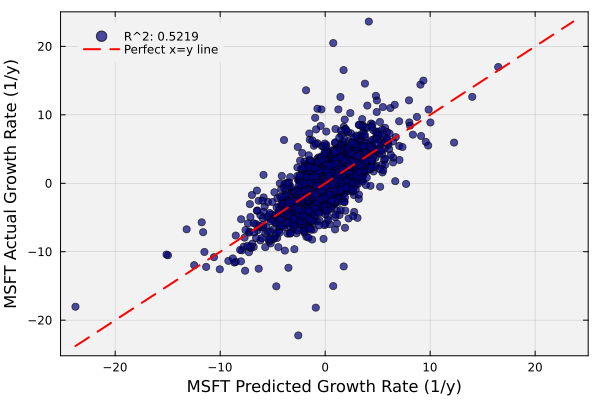

In [30]:
let 

    # initialize -
    parameters = parameters_theory_dict[ticker_of_interest]; # get the parameters for the ticker of interest
    i = findfirst(x-> x== ticker_of_interest, list_of_tickers);  # index of the ticker of interest
    yᵢ = growth_rate_array[:, i];  # get the growth values for ticker
    T = length(yᵢ); # number of time steps
    X̂ = [ones(T) Gₘ]; # design matrix
    θ̂ᵢ = [parameters.alpha; parameters.beta]; # parameter estimates
    ŷᵢ = X̂ * θ̂ᵢ; # predicted values

    # Create x=y line data
    min_val = min(minimum(ŷᵢ), minimum(yᵢ))
    max_val = max(maximum(ŷᵢ), maximum(yᵢ))
    xy_line = [min_val, max_val]

    # plot -
    scatter(ŷᵢ, yᵢ, color = :navy, label="R^2: $(RS |> x-> round(x, digits=4))",
        markersize=4, alpha=0.7, legend=:topleft)
    plot!(xy_line, xy_line, color=:red, linestyle=:dash, lw=2, label="Perfect x=y line")
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("$(ticker_of_interest) Predicted Growth Rate (1/y)")
    ylabel!("$(ticker_of_interest) Actual Growth Rate (1/y)")
end

## Task 3: Compute Parameter Uncertainty using Bootstrapping
In this task, we'll compute the parameter uncertainty for the $\alpha$ and $\beta$ parameters of the single index model using bootstrapping. 
> __What is Bootstrapping?__ Bootstrapping is a resampling technique that allows us to estimate the distribution of a statistic (in this case, the parameters) by repeatedly resampling the data. In our case, we'll create multiple __synthetic datasets__, estimate the parameters from each dataset, and then analyze the distribution of these estimates to compute confidence intervals.

Let's look at some pseudocode for how we might implement this simulation.

__Initialization:__ Given the design matrix $\hat{\mathbf{X}}$, the estimated parameters $\hat{\boldsymbol{\theta}}$ and the error variance $\hat{\sigma}^2$ from our observed data, a value for the regularization parameter $\delta\geq{0}$ and the number of samples to generate $K$. 

For each $k = 1, 2, \ldots, K$: __do__:
1. Generate synthetic errors: $\boldsymbol{\varepsilon}^{(k)} \sim \mathcal{N}(\mathbf{0}, \Delta{t}\;\hat{\sigma}^2\;\mathbf{I})$
2. Create synthetic observations: $\mathbf{y}^{(k)} \gets \hat{\mathbf{X}}\;\hat{\boldsymbol{\theta}} + \boldsymbol{\varepsilon}^{(k)}$
3. Estimate parameters from the synthetic observation: $\hat{\boldsymbol{\theta}}^{(k)} \gets \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}} + \delta\;\mathbf{I}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y}^{(k)}$

Analyze the empirical distribution of $\left\{\hat{\boldsymbol{\theta}}^{(1)}, \hat{\boldsymbol{\theta}}^{(2)}, \ldots, \hat{\boldsymbol{\theta}}^{(K)}\right\}$.

Let's start by generating synthetic datasets by resampling the original dataset.

In [32]:
synthetic_datasets = let

    # initialize -
    parameters = parameters_theory_dict[ticker_of_interest]; # get the parameters for the ticker of interest
    num_bootstrap_samples = 1000; # number of bootstrap samples
    T = maximum_number_trading_days - 1; # number of time steps
    n = T; # number of observations
    i = findfirst(x-> x== ticker_of_interest, list_of_tickers);  # index of the ticker of interest
    yᵢ = growth_rate_array[:, i];  # get the growth values for ticker
    T = length(yᵢ); # number of time steps
    X̂ = [ones(T) Gₘ]; # design matrix
    θ̂ᵢ = [parameters.alpha; parameters.beta]; # parameter estimates
    ŷᵢ = X̂ * θ̂ᵢ; # predicted values
    synthetic_datasets = Array{Float64, 2}(undef, n, num_bootstrap_samples); # 2D array to hold synthetic datasets

    # compute residuals, fit to a normal distribution, and generate synthetic datasets
    rᵢ = yᵢ .- ŷᵢ; # residual vector 
    d = fit_mle(Normal, rᵢ); # fit residuals to a normal distribution

    for s ∈ 1:num_bootstrap_samples
        resampled_residuals = rand(d, n); # resample residuals from the fitted normal distribution
        synthetic_datasets[:, s] = ŷᵢ .+ resampled_residuals; # create synthetic dataset
    end
    
    synthetic_datasets; # return
end

2766×1000 Matrix{Float64}:
 -4.05326     1.32292   -0.39924    …   0.462871  -2.53967   -2.49221
 -0.280039    1.20108    2.64528        2.3953     2.84157    1.40542
  3.17144    -0.512855   1.25748        0.602209  -0.520374  -3.90507
  2.30643     4.70734   -3.591         -0.240111   0.096268  -1.91514
 -3.99084     2.09176    0.334977      -1.24527   -3.93786    0.552332
 -1.59973    -3.00622   -0.0189198  …  -2.58277    1.88282   -1.07899
  0.0115903   2.22       7.49095        2.29646   -0.459088   0.79912
  5.30733     3.43395    6.66803       -0.333582   3.1943     5.26724
  3.80804     4.53776   -1.74059        3.39684   -0.635276   0.649227
 -0.196543   -1.07154   -2.32875        0.412962  -1.95015   -0.491745
  1.87697     1.60727   -0.0434793  …  -1.55681   -2.64327   -0.783802
 -3.24268     1.26577   -1.30371        1.55366    2.59069   -2.78896
 -6.57053    -3.91434   -2.12073       -3.65624   -5.41704   -1.25606
  ⋮                                 ⋱                      

Next, we estimate the single index model parameters from each synthetic dataset. For each bootstrap sample (synthetic sample), we compute the $\alpha$ and $\beta$ parameters using ordinary least squares. 

We store the parameter estimates in the `synthetic_parameter_array::Array{Float64,2}` variable, where each column corresponds to a bootstrap sample. The first row contains the $\alpha$ estimates, while the second row contains the $\beta$ estimates:

In [34]:
synthetic_parameter_array = let
    
    num_bootstrap_samples = size(synthetic_datasets, 2); # number of bootstrap samples
    T = size(synthetic_datasets, 1); # number of time steps
    p = 2; # number of parameters
    synthetic_parameter_array = Array{Float64, 2}(undef, p, num_bootstrap_samples); # 2D array to hold parameter estimates

    X̂ = [ones(T) Gₘ]; # design matrix

    for s ∈ 1:num_bootstrap_samples
        y_s = synthetic_datasets[:, s]; # get the synthetic dataset
        θ̂_s = inv(transpose(X̂) * X̂) * transpose(X̂) * y_s; # compute the SIM parameters for the synthetic dataset
        synthetic_parameter_array[:, s] = θ̂_s; # save the parameters
    end

    synthetic_parameter_array; # return
end

2×1000 Matrix{Float64}:
 0.17022  0.0580601  0.09361  0.153137  …  0.121939  0.0679039  0.07969
 1.15822  1.18156    1.16775  1.13773      1.14264   1.13192    1.17708

Finally, let's compare the bootstrap confidence intervals with the theoretical confidence intervals. We compute the mean and standard deviation of the bootstrap parameter estimates, then construct 95% confidence intervals and display them alongside the theoretical results we computed earlier.

> __What do we expect to see?__ We expect that as the number of bootstrap samples increases, the bootstrap confidence intervals will converge to the theoretical confidence intervals. This would validate our theoretical estimates and demonstrate that bootstrapping provides a practical method for assessing parameter uncertainty.

Is this what happens? Let's see:

In [36]:
let

    # initialize -
    parameters = parameters_theory_dict[ticker_of_interest]; # get the parameters for the ticker of interest
    x̄ = mean(synthetic_parameter_array, dims=2); # mean of the bootstrap parameter estimates
    σ = std(synthetic_parameter_array, dims=2); # standard deviation of the bootstrap parameter estimates
    t = 1.96; # for a 95% confidence interval
    df = DataFrame();

    # alpha -
    row_df = (
        parameter = "alpha",
        original_estimate = parameters.alpha,
        CI_95_lower = parameters.alpha_95_CI_lower,
        CI_95_upper = parameters.alpha_95_CI_upper,
        bootstrap_mean = x̄[1],
        B_CI_95_lower = x̄[1] - t*σ[1],
        B_CI_95_upper = x̄[1] + t*σ[1]
    );
    push!(df, row_df);

    # beta -
    row_df = (
        parameter = "beta",
        original_estimate = parameters.beta,
        CI_95_lower = parameters.beta_95_CI_lower,
        CI_95_upper = parameters.beta_95_CI_upper,
        bootstrap_mean = x̄[2],
        B_CI_95_lower = x̄[2] - t*σ[2],
        B_CI_95_upper = x̄[2] + t*σ[2]
    );
    push!(df, row_df);


   # build a table -
    pretty_table(df, backend = :text, fit_table_in_display_horizontally = false,
        fit_table_in_display_vertically = false, table_format = TextTableFormat(borders = text_table_borders__compact))
end

 ----------- ------------------- ------------- ------------- ---------------- --------------- ---------------
  parameter   original_estimate   CI_95_lower   CI_95_upper   bootstrap_mean   B_CI_95_lower   B_CI_95_upper 
     String             Float64       Float64       Float64          Float64         Float64         Float64 
 ----------- ------------------- ------------- ------------- ---------------- --------------- ---------------
      alpha           0.0999256     0.0116594      0.188192         0.100745       0.0109054        0.190584
       beta             1.15201       1.11091       1.19312          1.15182         1.10952         1.19413
 ----------- ------------------- ------------- ------------- ---------------- --------------- ---------------


___

## Summary
In this example, we estimated single index models for firms in our dataset and quantified the uncertainty in our parameter estimates using both theoretical and simulation-based approaches.

> __Key Takeaways:__
>
> * __Parameter estimation:__ We estimated $\alpha$ and $\beta$ parameters for all firms using ordinary least squares regression, computing 95% confidence intervals based on standard errors derived from residual variance.
> * __Model evaluation:__ R-squared values quantify the fraction of a firm's growth rate variance explained by the market index, with values closer to 1 indicating stronger market correlation.
> * __Uncertainty quantification:__ Bootstrap simulation results closely matched theoretical confidence intervals, validating our uncertainty estimates and demonstrating that parametric bootstrap provides a practical method for assessing parameter reliability.

These methods provide the foundation for understanding parameter uncertainty in single index models, which is important for robust portfolio construction and risk management decisions.

___

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.